- the github link: https://github.com/msjw-cloud/ICS471_Project.git
- you can find the project there and upload it here

# Simple LSTM
(Don't Run This Code)

In [ ]:
class S_CSLRLSTM(nn.Module):
    def __init__(self, num_classes, input_dim=42, hidden_size=256,
                 num_layers=2, bidirectional=True, dropout=0.1):
        super().__init__()

        self.hidden_size = hidden_size
        self.bidirectional = bidirectional

        self.input_proj = nn.Linear(input_dim * 2, hidden_size)

        self.lstm = nn.LSTM(
            input_size=hidden_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout if num_layers > 1 else 0.0,
        )

        lstm_out_dim = hidden_size * (2 if bidirectional else 1)
        self.fc = nn.Linear(lstm_out_dim, num_classes)

    def forward(self, poses):
        poses = poses.view(poses.shape[0], poses.shape[1], -1)
        x = self.input_proj(poses)
        x, _ = self.lstm(x)
        logits = self.fc(x)
        return logits

# Improved LSTM
(Don't Run This Code)

In [ ]:
class C_CSLRLSTM(nn.Module):
    """
    Improved BiLSTM model for CSLR.

    Changes vs old version:
    - Stronger per-frame embedding: Linear + LayerNorm + ReLU + Dropout
    - Two stacked BiLSTM blocks with residual connection
    - MLP classifier head with non-linearity and dropout
    """
    def __init__(self, num_classes, input_dim=42, hidden_size=256,
                 num_layers=2, bidirectional=True, dropout=0.2):
        super().__init__()

        self.hidden_size = hidden_size
        self.bidirectional = bidirectional

        # 1) Stronger input projection (J*2 -> hidden_size)
        #    Old: just Linear
        #    New: Linear + LayerNorm + ReLU + Dropout
        self.input_proj = nn.Sequential(
            nn.Linear(input_dim * 2, hidden_size),
            nn.LayerNorm(hidden_size),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
        )

        # 2) First BiLSTM block
        self.lstm1 = nn.LSTM(
            input_size=hidden_size,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True,          # [B, T, H]
            bidirectional=bidirectional,
            dropout=0.0,
        )

        # 3) Second BiLSTM block (takes output of first)
        self.lstm2 = nn.LSTM(
            input_size=hidden_size * (2 if bidirectional else 1),
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=0.0,
        )

        # Output dimension of BiLSTM
        self.lstm_out_dim = hidden_size * (2 if bidirectional else 1)

        # 4) Classifier head: small MLP instead of single Linear
        self.classifier = nn.Sequential(
            nn.Linear(self.lstm_out_dim, hidden_size),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, num_classes),
        )

        print("MODEL: IMPROVED_BILSTM")

    def forward(self, poses):
        # poses: [B, T, J, 2] -> [B, T, J*2]
        B, T, J, _ = poses.shape
        poses = poses.view(B, T, -1)              # [B, T, J*2]

        # 1) Per-frame embedding
        x = self.input_proj(poses)                # [B, T, H]

        # 2) First BiLSTM block
        x1, _ = self.lstm1(x)                     # [B, T, H*(2 if bi else 1)]

        # 3) Second BiLSTM block
        x2, _ = self.lstm2(x1)                    # same shape as x1

        # 3b) Residual connection between LSTM blocks (if shapes match)
        #     This helps gradients flow and stabilizes training.
        if x1.shape == x2.shape:
            x = x1 + x2
        else:
            x = x2

        # 4) Time-distributed classifier
        logits = self.classifier(x)               # [B, T, num_classes]

        return logits

# Improved Transformer
(Don't Run This Code)

In [ ]:
class ImprovedCSLRTransformer(nn.Module):
    """
    Improved encoder-only Transformer for CSLR.

    Improvements vs BasicCSLRTransformer:
    1) Stronger per-frame embedding: Linear + LayerNorm + GELU + Dropout
    2) Deeper & wider Transformer encoder (more layers, larger feedforward)
    3) Temporal Conv (TCN-style) head to capture local motion patterns
    4) More expressive classifier head: MLP with non-linearity + dropout
    """
    def __init__(
        self,
        num_classes,
        input_dim=42,          # number of keypoints (J); you will pass 86
        d_model=256,
        nhead=4,
        num_layers=4,
        dim_feedforward=1024,
        dropout=0.1,
    ):
        super().__init__()

        self.d_model = d_model

        # 1) Stronger input embedding
        #    [B, T, J*2] -> [B, T, d_model], with normalization & non-linearity
        self.input_proj = nn.Sequential(
            nn.Linear(input_dim * 2, d_model),
            nn.LayerNorm(d_model),
            nn.GELU(),          # smoother than ReLU
            nn.Dropout(dropout),
        )

        # 2) Same sinusoidal positional encoding, but now feeding a richer embedding
        self.pos_encoder = SinusoidalPositionalEncoding(d_model)

        # 3) Deeper Transformer encoder stack
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,
        )
        self.encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers,
        )

        # 4) Temporal Conv head (TCN-style) on top of encoder output
        #    This helps capture local motion patterns (short-term dynamics)
        self.tcn = nn.Sequential(
            nn.Conv1d(d_model, d_model, kernel_size=3, padding=1, dilation=1),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Conv1d(d_model, d_model, kernel_size=3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
        )

        # 5) More expressive classifier head (MLP)
        self.classifier = nn.Sequential(
            nn.Linear(d_model, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(256, num_classes),
        )

        print("MODEL: IMPROVED_ENCODER_ONLY_TRANSFORMER")

    def forward(self, poses):
        """
        poses: [B, T, J, 2]
        returns logits: [B, T, num_classes]
        """
        B, T, J, _ = poses.shape

        # Flatten joints: [B, T, J, 2] -> [B, T, J*2]
        x = poses.view(B, T, -1)                   # [B, T, J*2]

        # 1) Embedding
        x = self.input_proj(x)                     # [B, T, d_model]

        # 2) Add positional encoding
        pos = self.pos_encoder(x)                  # [B, T, d_model]
        x = x + pos.to(x.device)                   # [B, T, d_model]

        # 3) Transformer encoder
        x = self.encoder(x)                        # [B, T, d_model]

        # 4) Temporal Conv head (keep time length T)
        x = x.transpose(1, 2)                      # [B, d_model, T]
        x = self.tcn(x)                            # [B, d_model, T]
        x = x.transpose(1, 2)                      # [B, T, d_model]

        # 5) Classifier
        logits = self.classifier(x)                # [B, T, num_classes]

        return logits

# Here we start running our project (train your models)

# Connect to your google Drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
!ls /content

drive  Pose86K-CSLR-Isharah  sample_data


# Extract the project and place it in /content
- Note: you should upload the zipped project into you drive
- download the project from github -> zip the project -> create My_Drive Folder in your drive -> place the zipped project file in My_Drive

In [6]:
import os, zipfile, shutil

# Path to your zip in Drive
zip_path = "/content/drive/MyDrive/My_Drive/Pose86K-CSLR-Isharah.zip"

# Unzip into /content
with zipfile.ZipFile(zip_path, 'r') as z:
    z.extractall('/content')

# Check contents
os.listdir('/content')


['.config', 'drive', 'Pose86K-CSLR-Isharah', 'sample_data']

In [4]:
!ls /content/Pose86K-CSLR-Isharah

annotations_v2	     fig      pos_env	      utils
data		     main.py  README.md       work_dir
data_loader_test.py  models   test_script.py


In [5]:
%cd /content/Pose86K-CSLR-Isharah

/content/Pose86K-CSLR-Isharah


# Download necssary Packages

In [6]:
!pip install tqdm pandas opencv-python

In [7]:
import torch
print("Torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())


Torch: 2.9.0+cu126
CUDA available: True


# Make Sure to create isharah_project folder inside My_Drive as the output will be stored there

# Train Simple LSTM
--wor_dir: the place where your output will be stored

In [8]:
!python main.py \
  --work_dir /content/drive/MyDrive/My_Drive/isharah_project/work_dir_SI_lstm \
  --data_dir ./data \
  --mode SI \
  --model lstm \
  --lr 0.0001 \
  --num_epochs 20

Current dir exists, do you want to remove and refresh it?
y
Extracted Vocabulary Size: 684
processsed train
processsed dev
Loaded 9500 samples for split: train
Loaded 949 samples for split: dev
MODEL: SIMPLE_BILSTM


Epoch [1/20]
valid: 100%|██████████████████████████████████████████████████████| 949/949 [00:22<00:00, 42.88it/s]
Train Loss: 244.9783 - Dev WER: 445.7934 - Best Dev WER: 445.7934 - Best epoch: 1 - Learning Rate: 0.00010000


Epoch [2/20]
valid: 100%|██████████████████████████████████████████████████████| 949/949 [00:21<00:00, 43.51it/s]
Train Loss: 235.8197 - Dev WER: 15631.0345 - Best Dev WER: 445.7934 - Best epoch: 1 - Learning Rate: 0.00010000


Epoch [3/20]
valid: 100%|██████████████████████████████████████████████████████| 949/949 [00:22<00:00, 43.04it/s]
Train Loss: 235.0667 - Dev WER: 1014.4231 - Best Dev WER: 445.7934 - Best epoch: 1 - Learning Rate: 0.00010000


Epoch [4/20]
valid: 100%|██████████████████████████████████████████████████████| 949/949 [00:22<00:00,

# Train Improved LSTM

In [8]:
!python main.py \
  --work_dir /content/drive/MyDrive/My_Drive/isharah_project/work_dir_SI_lstm_improved \
  --data_dir ./data \
  --mode SI \
  --model lstm_improved \
  --lr 0.0001 \
  --num_epochs 30

Extracted Vocabulary Size: 684
processsed train
processsed dev
Loaded 9500 samples for split: train
Loaded 949 samples for split: dev
MODEL: IMPROVED_BILSTM


Epoch [1/30]
valid: 100%|██████████████████████████████████████████████████████| 949/949 [00:22<00:00, 42.01it/s]
Train Loss: 243.4465 - Dev WER: 50466.6667 - Best Dev WER: 50466.6667 - Best epoch: 1 - Learning Rate: 0.00010000


Epoch [2/30]
valid: 100%|██████████████████████████████████████████████████████| 949/949 [00:22<00:00, 42.65it/s]
Train Loss: 235.4558 - Dev WER: 1215.2299 - Best Dev WER: 1215.2299 - Best epoch: 2 - Learning Rate: 0.00010000


Epoch [3/30]
valid: 100%|██████████████████████████████████████████████████████| 949/949 [00:22<00:00, 42.66it/s]
Train Loss: 233.9727 - Dev WER: 1304.6154 - Best Dev WER: 1215.2299 - Best epoch: 2 - Learning Rate: 0.00010000


Epoch [4/30]
valid: 100%|██████████████████████████████████████████████████████| 949/949 [00:22<00:00, 42.04it/s]
Train Loss: 226.0338 - Dev WER: 1352.2293

# Train Improved Transformer

In [9]:
!python main.py \
  --work_dir /content/drive/MyDrive/My_Drive/isharah_project/work_dir_SI_transformer_improved \
  --data_dir ./data \
  --mode SI \
  --model transformer_improved \
  --lr 0.0001 \
  --num_epochs 30

Extracted Vocabulary Size: 684
processsed train
processsed dev
Loaded 9500 samples for split: train
Loaded 949 samples for split: dev
MODEL: IMPROVED_ENCODER_ONLY_TRANSFORMER


Epoch [1/30]
valid: 100%|██████████████████████████████████████████████████████| 949/949 [00:16<00:00, 57.71it/s]
Train Loss: 241.3230 - Dev WER: 1139.8922 - Best Dev WER: 1139.8922 - Best epoch: 1 - Learning Rate: 0.00010000


Epoch [2/30]
valid: 100%|██████████████████████████████████████████████████████| 949/949 [00:16<00:00, 58.16it/s]
Train Loss: 234.7919 - Dev WER: 837.0000 - Best Dev WER: 837.0000 - Best epoch: 2 - Learning Rate: 0.00010000


Epoch [3/30]
valid: 100%|██████████████████████████████████████████████████████| 949/949 [00:16<00:00, 58.11it/s]
Train Loss: 233.5821 - Dev WER: 395.3033 - Best Dev WER: 395.3033 - Best epoch: 3 - Learning Rate: 0.00010000


Epoch [4/30]
valid: 100%|██████████████████████████████████████████████████████| 949/949 [00:15<00:00, 60.17it/s]
Train Loss: 232.5058 - Dev WE

# Plot and see which performed better across epoch

lstm_improved: 24 epochs, best WER = 246.6406
lstm: 14 epochs, best WER = 214.6943
transformer_improved: 24 epochs, best WER = 55.7601


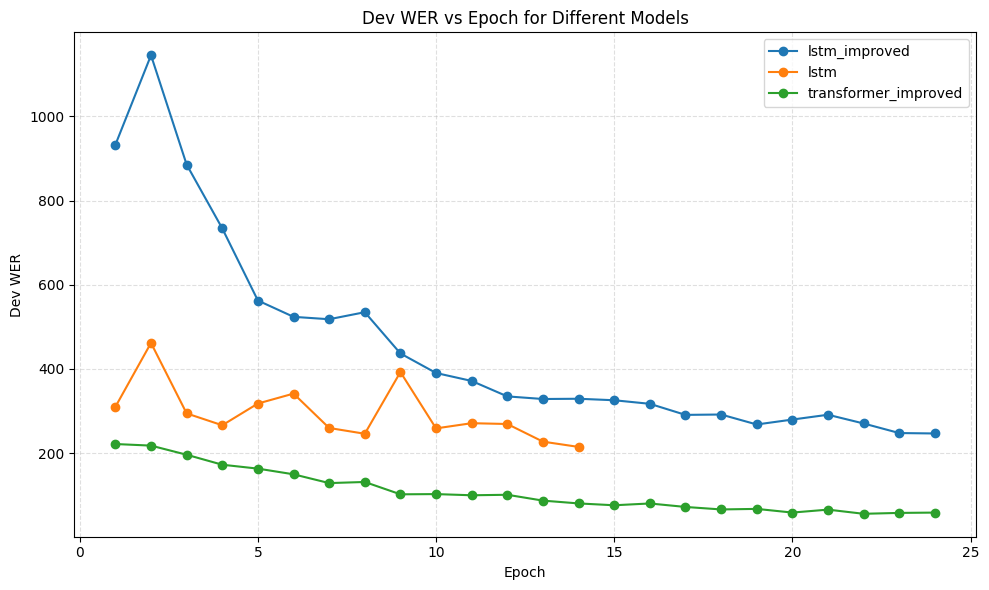


# Best model overall: transformer_improved with best Dev WER = 55.7601


In [12]:
import os
import re
import matplotlib.pyplot as plt

# Edit these paths if you changed them
work_dirs = {
    "lstm_improved": "/content/drive/MyDrive/My_Drive/isharah_project/work_dir_SI_lstm_improved",
    "lstm": "/content/drive/MyDrive/My_Drive/isharah_project/work_dir_SI_lstm",
    "transformer_improved": "/content/drive/MyDrive/My_Drive/isharah_project/work_dir_SI_transformer_improved",
}

def parse_wer_per_epoch(log_path):
    """
    Parse 'Dev WER: X' per epoch from training_log.txt
    Returns: list of WER values in order of epochs
    """
    wers = []
    if not os.path.exists(log_path):
        print(f"Log file not found: {log_path}")
        return wers

    with open(log_path, "r") as f:
        for line in f:
            if "Dev WER:" in line:
                # Example line:
                # Train Loss: 174.4052 - Dev WER: 268.0196 - Best Dev WER: ...
                match = re.search(r"Dev WER:\s*([0-9.]+)", line)
                if match:
                    wer = float(match.group(1))
                    wers.append(wer)
    return wers[6:]

all_histories = {}

for name, wd in work_dirs.items():
    log_file = os.path.join(wd, "training_log.txt")
    wers = parse_wer_per_epoch(log_file)
    if wers:
        all_histories[name] = wers
        print(f"{name}: {len(wers)} epochs, best WER = {min(wers):.4f}")
    else:
        print(f"{name}: no WER data found")

# Plot
plt.figure(figsize=(10, 6))

for name, wers in all_histories.items():
    epochs = list(range(1, len(wers) + 1))
    plt.plot(epochs, wers, marker="o", label=name)

plt.xlabel("Epoch")
plt.ylabel("Dev WER")
plt.title("Dev WER vs Epoch for Different Models")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

# Comment: who is best (lower WER is better)
best_model = None
best_wer = float("inf")
for name, wers in all_histories.items():
    model_best = min(wers)
    if model_best < best_wer:
        best_wer = model_best
        best_model = name

print(f"\n# Best model overall: {best_model} with best Dev WER = {best_wer:.4f}")
# Based on your logs, this should be: transformer_improved with WER ≈ 55.76


# GT vs Prediction output
## this will be shown in ishara_project created earlier

to run the following code, you should upload the prediction output of the final epoch of each model to /content

these outputs should be found in /content/drive/MyDrive/My_Drive/isharah_project/work_dir_SI_{what you specified when training} \

In [8]:
import os

# Paths to your three files in /content
paths = {
    "SIMPLE LSTM (epoch 20)": "/content/predictions_epoch_20_lstm.txt",
    "IMPROVED LSTM (epoch 30)": "/content/predictions_epoch_30_lstm_improved.txt",
    "IMPROVED TRANSFORMER (epoch 30)": "/content/predictions_epoch_30_transformer_improved.txt",
}

def load_gt_pred_pairs(path, max_samples=5):
    """Parse a predictions file and return up to max_samples (GT, Pred) pairs."""
    pairs = []
    if not os.path.exists(path):
        print(f"[WARN] File not found: {path}")
        return pairs

    with open(path, "r", encoding="utf-8") as f:
        lines = [l.strip() for l in f.readlines()]

    i = 0
    while i < len(lines) and len(pairs) < max_samples:
        line = lines[i]
        if line.startswith("GT:"):
            gt = line.replace("GT:", "").strip()
            # look ahead for the corresponding Pred line
            j = i + 1
            pred = ""
            while j < len(lines):
                if lines[j].startswith("Pred:"):
                    pred = lines[j].replace("Pred:", "").strip()
                    break
                j += 1
            pairs.append((gt, pred))
            i = j + 1  # jump after Pred line
        else:
            i += 1
    return pairs

# Show samples from each model
for model_name, path in paths.items():
    print("=" * 80)
    print(f"{model_name}  |  file: {os.path.basename(path)}")
    print("=" * 80)
    samples = load_gt_pred_pairs(path, max_samples=8)  # change 8 to whatever you want
    if not samples:
        print("No pairs found or file missing.\n")
        continue

    for idx, (gt, pred) in enumerate(samples, start=1):
        print(f"Sample {idx}:")
        print(f"  GT  : {gt}")
        print(f"  Pred: {pred}")
        print()


SIMPLE LSTM (epoch 20)  |  file: predictions_epoch_20_lstm.txt
Sample 1:
  GT  : سوال هو
  Pred: هو

Sample 2:
  GT  : هو معلم لغه اشاره
  Pred: هو لغه اشاره

Sample 3:
  GT  : استفهام هو معلم هو
  Pred: دراجه

Sample 4:
  GT  : هو معلم لا انا مدرسه
  Pred: هو مدرسه

Sample 5:
  GT  : هو سوال
  Pred: هو سوال

Sample 6:
  GT  : هو صديق مدرسه
  Pred: هو مدرسه

Sample 7:
  GT  : استفهام هو صديق مدرسه
  Pred: استفهام مدرسه

Sample 8:
  GT  : انا اسره رقم ثلاث اشخاص
  Pred: انا صباح

IMPROVED LSTM (epoch 30)  |  file: predictions_epoch_30_lstm_improved.txt
Sample 1:
  GT  : سوال هو
  Pred: هو

Sample 2:
  GT  : هو معلم لغه اشاره
  Pred: هو لغه اشاره

Sample 3:
  GT  : استفهام هو معلم هو
  Pred: هو

Sample 4:
  GT  : هو معلم لا انا مدرسه
  Pred: انا مدرسه

Sample 5:
  GT  : هو سوال
  Pred: هو سوال

Sample 6:
  GT  : هو صديق مدرسه
  Pred: مدرسه

Sample 7:
  GT  : استفهام هو صديق مدرسه
  Pred: مدرسه

Sample 8:
  GT  : انا اسره رقم ثلاث اشخاص
  Pred: انا لا

IMPROVED TRANSFORMER (epoch 30)  |  